In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
from math import floor
from termcolor import colored as cl 


from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

## Generate Dataset
---

In [2]:
# set ticker
ticker = "SPY"

# set timeframe for data
start = '2001-01-01'
end = '2021-01-01'

# pull historical stock data from 1/10/2005 to 3/8/2021
yf.pdr_override()
stock_data = pdr.get_data_yahoo(ticker, start=start, end=end)

# drop Dividends and Stock Split columns
stock_data = stock_data.drop(columns=['Adj Close'])
stock_data.head()

[*********************100%***********************]  1 of 1 completed


Open       High        Low       Close    Volume
Date                                                             
2001-01-02  132.00000  132.15625  127.56250  128.812500   8737500
2001-01-03  128.31250  136.00000  127.65625  135.000000  19431600
2001-01-04  134.93750  135.46875  133.00000  133.546875   9219000
2001-01-05  133.46875  133.62500  129.18750  129.187500  12911400
2001-01-08  129.87500  130.18750  127.68750  130.187500   6625300

### Filter the dataset

In [3]:
# Filter the date index and close columns
signals_df = stock_data.loc[:, ["Close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Add in a binary classifier for positive and negative price changes. Set threshold at +/- 0.10%
signals_df['Target'] = (
    (np.where(signals_df['Actual Returns'] > 0.001, 1.0, 0.0)) + 
    (np.where(signals_df['Actual Returns'] < -0.001, -1.0, 0.0))
)

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

Close  Actual Returns  Target
Date                                          
2001-01-03  135.000000        0.048035     1.0
2001-01-04  133.546875       -0.010764    -1.0
2001-01-05  129.187500       -0.032643    -1.0
2001-01-08  130.187500        0.007741     1.0
2001-01-09  129.843750       -0.002640    -1.0

Close  Actual Returns  Target
Date                                          
2020-12-24  369.000000        0.003890     1.0
2020-12-28  372.170013        0.008591     1.0
2020-12-29  371.459991       -0.001908    -1.0
2020-12-30  371.989990        0.001427     1.0
2020-12-31  373.880005        0.005081     1.0

## Generate trading signals
---

### RSI

RSI = 100 – [100 / ( 1 + (EMA_up / EMA_down) ) ] where,

EMAup = Exponential Moving Average of Upward Price Change

EMAdown = Exponential Moving Average of Downward Price Change

In [4]:
# Set RSI trading window
RSI_window = 14

#create new df for bollinger bands
RSI_df = signals_df.copy()

#Create function for RSI calculation
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

RSI_df [f'rsi'] = get_rsi(RSI_df['Close'], RSI_window)
RSI_df = RSI_df.dropna()
RSI_df

Close  Actual Returns  Target        rsi
Date                                                     
2001-01-09  129.843750       -0.002640    -1.0  14.989957
2001-01-10  132.125000        0.017569     1.0  39.130315
2001-01-11  132.250000        0.000946     0.0  40.133496
2001-01-12  132.000000       -0.001890    -1.0  38.757710
2001-01-16  132.843750        0.006392     1.0  45.542829
...                ...             ...     ...        ...
2020-12-24  369.000000        0.003890     1.0  59.393365
2020-12-28  372.170013        0.008591     1.0  63.892088
2020-12-29  371.459991       -0.001908    -1.0  62.229130
2020-12-30  371.989990        0.001427     1.0  63.003210
2020-12-31  373.880005        0.005081     1.0  65.702598

[5027 rows x 4 columns]

In [5]:
#RSI Trading Signal

upper_limit = 70
lower_limit = 30


# Calculate rolling mean and standard deviation
RSI_df['RSI_mid_band'] = RSI_df['Close'].rolling(window=RSI_window).mean()
RSI_df['RSI_std'] = RSI_df['Close'].rolling(window=14).std()

# Calculate upper and lowers bands of bollinger band
RSI_df['RSI_upper_band']  = RSI_df['RSI_mid_band'] + (RSI_df['RSI_std'] * 1)
RSI_df['RSI_lower_band']  = RSI_df['RSI_mid_band'] - (RSI_df['RSI_std'] * 1)


# Calculate RSI trading signal
RSI_df['RSI_long'] = np.where(RSI_df['rsi'] < lower_limit, 1.0, 0.0)
RSI_df['RSI_short'] = np.where(RSI_df['rsi'] > upper_limit, -1.0, 0.0)
RSI_df['RSI_signal'] = RSI_df['RSI_long'] + RSI_df['RSI_short']

    
RSI_df['RSI_signal'].value_counts()

 0.0    4618
-1.0     310
 1.0      99
Name: RSI_signal, dtype: int64

<AxesSubplot:xlabel='Date'>

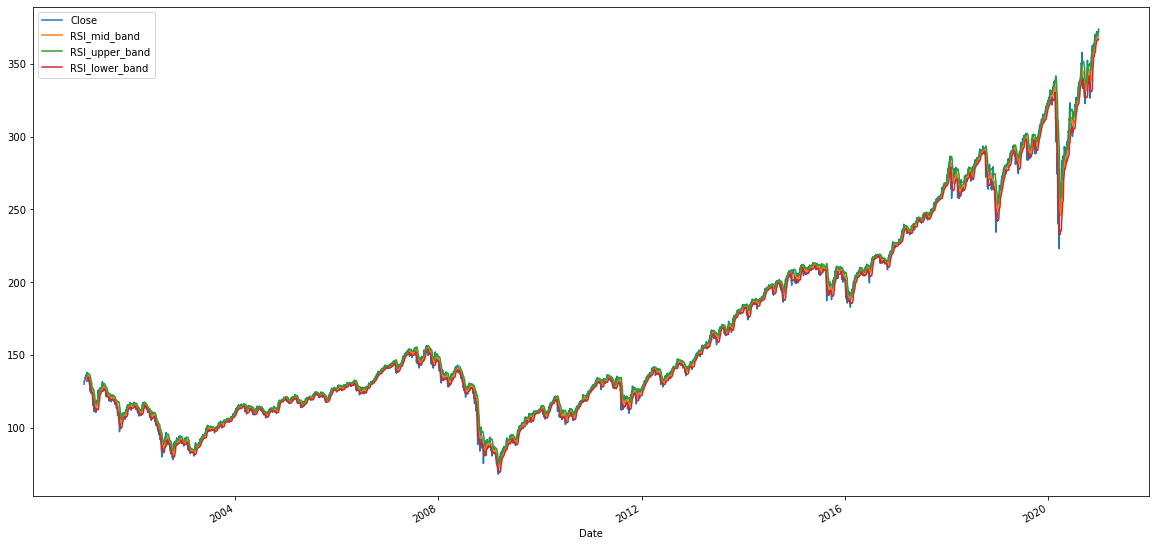

In [6]:
# Plot the RSI for closing prices
RSI_df[['Close','RSI_mid_band','RSI_upper_band','RSI_lower_band']].plot(figsize=(20,10))

In [7]:
# Calculate the strategy returns and add them to the signals_df DataFrame
RSI_df['Strategy Returns'] = RSI_df['Actual Returns'] * RSI_df['RSI_signal'].shift()

# Calculate the points in time at which a position should be taken, 1 or -1
RSI_df['Entry/Exit'] = RSI_df['RSI_signal'].diff()

# # Visualize exit position relative to close price
RSI_df['exit'] = RSI_df[RSI_df['Entry/Exit'] == -1.0]['Close']
RSI_df['entry'] = RSI_df[RSI_df['Entry/Exit'] == 1.0]['Close']

# Review the DataFrame
display(RSI_df.head())
display(RSI_df.tail())

Close  Actual Returns  Target        rsi  RSI_mid_band  \
Date                                                                     
2001-01-09  129.84375       -0.002640    -1.0  14.989957           NaN   
2001-01-10  132.12500        0.017569     1.0  39.130315           NaN   
2001-01-11  132.25000        0.000946     0.0  40.133496           NaN   
2001-01-12  132.00000       -0.001890    -1.0  38.757710           NaN   
2001-01-16  132.84375        0.006392     1.0  45.542829           NaN   

            RSI_std  RSI_upper_band  RSI_lower_band  RSI_long  RSI_short  \
Date                                                                       
2001-01-09      NaN             NaN             NaN       1.0        0.0   
2001-01-10      NaN             NaN             NaN       0.0        0.0   
2001-01-11      NaN             NaN             NaN       0.0        0.0   
2001-01-12      NaN             NaN             NaN       0.0        0.0   
2001-01-16      NaN             NaN             NaN       0.0        0.0   

            RSI_signal  Strategy Returns  Entry/Exit     exit  entry  
Date                                                                  
2001-01-09         1.0               NaN         NaN      NaN    NaN  
2001-01-10         0.0          0.017569        -1.0  132.125    NaN  
2001-01-11         0.0          0.000000         0.0      NaN    NaN  
2001-01-12         0.0         -0.000000         0.0      NaN    NaN  
2001-01-16         0.0          0.000000         0.0      NaN    NaN

Close  Actual Returns  Target        rsi  RSI_mid_band  \
Date                                                                      
2020-12-24  369.000000        0.003890     1.0  59.393365    368.332142   
2020-12-28  372.170013        0.008591     1.0  63.892088    368.552144   
2020-12-29  371.459991       -0.001908    -1.0  62.229130    368.644285   
2020-12-30  371.989990        0.001427     1.0  63.003210    369.011427   
2020-12-31  373.880005        0.005081     1.0  65.702598    369.522141   

             RSI_std  RSI_upper_band  RSI_lower_band  RSI_long  RSI_short  \
Date                                                                        
2020-12-24  1.955714      370.287856      366.376428       0.0        0.0   
2020-12-28  2.204888      370.757032      366.347255       0.0        0.0   
2020-12-29  2.302493      370.946778      366.341792       0.0        0.0   
2020-12-30  2.402024      371.413451      366.609403       0.0        0.0   
2020-12-31  2.629024      372.151164      366.893117       0.0        0.0   

            RSI_signal  Strategy Returns  Entry/Exit  exit  entry  
Date                                                               
2020-12-24         0.0               0.0         0.0   NaN    NaN  
2020-12-28         0.0               0.0         0.0   NaN    NaN  
2020-12-29         0.0              -0.0         0.0   NaN    NaN  
2020-12-30         0.0               0.0         0.0   NaN    NaN  
2020-12-31         0.0               0.0         0.0   NaN    NaN

### Bollinger Bands

In [8]:
# Set bollinger band window
bollinger_window = 20

#create new df for bollinger bands
bb_df = signals_df.copy()

# Calculate rolling mean and standard deviation
bb_df['bollinger_mid_band'] = bb_df['Close'].rolling(window=bollinger_window).mean()
bb_df['bollinger_std'] = bb_df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
bb_df['bollinger_upper_band']  = bb_df['bollinger_mid_band'] + (bb_df['bollinger_std'] * 1)
bb_df['bollinger_lower_band']  = bb_df['bollinger_mid_band'] - (bb_df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
bb_df['bollinger_long'] = np.where(bb_df['Close'] < bb_df['bollinger_lower_band'], 1.0, 0.0)
bb_df['bollinger_short'] = np.where(bb_df['Close'] > bb_df['bollinger_upper_band'], -1.0, 0.0)
bb_df['bollinger_signal'] = bb_df['bollinger_long'] + bb_df['bollinger_short']


bb_df['bollinger_signal'].value_counts()

 0.0    2122
-1.0    1900
 1.0    1009
Name: bollinger_signal, dtype: int64

<AxesSubplot:xlabel='Date'>

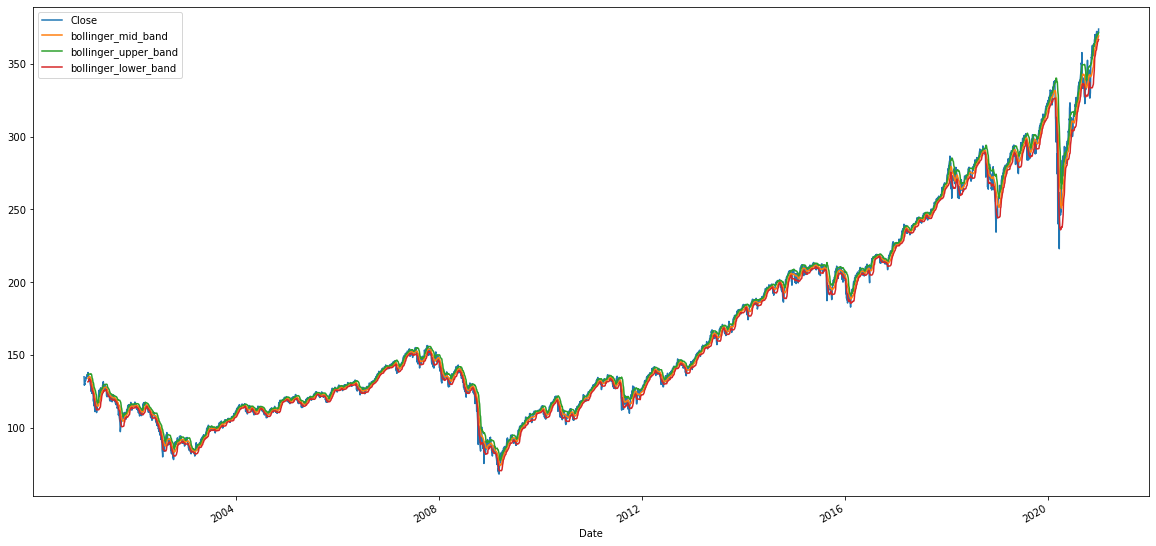

In [9]:
# Plot the Bollinger Bands for closing prices
bb_df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

## EMA

In [10]:
ema_df = stock_data.loc[:, ["Close"]]

short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
ema_df['fast_close'] = ema_df['Close'].ewm(halflife=short_window).mean()
ema_df['slow_close'] = ema_df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
ema_df['crossover_long'] = np.where(ema_df['fast_close'] > ema_df['slow_close'], 1.0, 0.0)
ema_df['crossover_short'] = np.where(ema_df['fast_close'] < ema_df['slow_close'], -1.0, 0.0)
ema_df['crossover_signal'] = ema_df['crossover_long'] + ema_df['crossover_short']


# Generate the short and long moving averages (50 and 100 days, respectively)
ema_df["SMA50"] = ema_df["Close"].rolling(window=short_window).mean()
ema_df["SMA100"] = ema_df["Close"].rolling(window=long_window).mean()
ema_df["Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
ema_df["Signal"][short_window:] = np.where(
    ema_df["SMA50"][short_window:] > ema_df["SMA100"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
ema_df["Entry/Exit"] = ema_df["Signal"].diff()


In [11]:
# Visualize exit position relative to close price
exit = ema_df[ema_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = ema_df[ema_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = ema_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize moving averages
moving_avgs = ema_df[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## SMA

In [12]:
# Set the windows
short_window = 50
long_window = 100

sma_df = signals_df.copy()

# Generate the short (50 days) and long moving averages(100 days) 
sma_df["SMA50"] = sma_df["Close"].rolling(window=short_window).mean()
sma_df["SMA100"] = sma_df["Close"].rolling(window=long_window).mean()
sma_df["Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
sma_df["Signal"][short_window:] = np.where(
    sma_df["SMA50"][short_window:] > sma_df["SMA100"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
sma_df["Entry/Exit"] = sma_df["Signal"].diff()


# Visualize exit point compared to closing price
exit = sma_df[sma_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in USD $',
    width=1100,
    height=600
)
# Visualize entry point compared to the closing price
entry = sma_df[sma_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in USD $',
    width=1100,
    height=600
)
# Visualize closing price
close_price = sma_df[['Close']].hvplot(
    line_color='lightblue',
    ylabel='Closing Price in USD $',
    width=1100,
    height=600
)
# Visualize moving averages
mv_avgs = sma_df[['SMA50', 'SMA100']].hvplot(
    ylabel='Closing Price in USD $',
    width=1100,
    height=600
)
# Generate the plots
entry_exit_plot = close_price * mv_avgs * entry * exit
entry_exit_plot.opts(xaxis=True)


:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## MACD

In [13]:
MACD_df = signals_df.copy()

# Calulate the Short and Long EMA
EMA_short = MACD_df.Close.ewm(span=12, adjust=False).mean()
EMA_long = MACD_df.Close.ewm(span=24, adjust=False).mean()

# Calculate the MACD
MACD = EMA_short - EMA_long

signal = MACD.ewm(span=9, adjust=False).mean()


MACD_df["MACD"] = MACD
MACD_df["Signal"] = signal
MACD_df

def entry_exit(signal):
    Entry = []
    Exit = []
    flag = -1
    
    for i in range(0, len(signal)):
        if signal["MACD"][i] > signal["Signal"][i]:
            Exit.append(np.nan)
            if flag != 1:
                Entry.append(signal["Close"][i])
                flag = 1
            else:
                Entry.append(np.nan)
        elif signal["MACD"][i] < signal["Signal"][i]:
            Entry.append(np.nan)
            if flag != 0:
                Exit.append(signal["Close"][i])
                flag = 0
            else:
                Exit.append(np.nan)
        else:
            Entry.append(np.nan)
            Exit.append(np.nan)
            
    return (Entry, Exit, flag)

data = entry_exit(MACD_df)
MACD_df["Entry_Point"] = data[0]
MACD_df["Exit_Point"] = data[1]
MACD_df["flag"] = data[2]



MACD_df['MACD Entry/Exit'] = MACD_df['Signal'].diff()

MACD_df.where(~MACD_df['Entry_Point'].notna(), 1) 

# MACD_df['flag'].value_counts()
MACD_df

Close  Actual Returns  Target      MACD    Signal  \
Date                                                                 
2001-01-03  135.000000        0.048035     1.0  0.000000  0.000000   
2001-01-04  133.546875       -0.010764    -1.0 -0.107308 -0.021462   
2001-01-05  129.187500       -0.032643    -1.0 -0.511445 -0.119458   
2001-01-08  130.187500        0.007741     1.0 -0.745909 -0.244748   
2001-01-09  129.843750       -0.002640    -1.0 -0.944635 -0.384726   
...                ...             ...     ...       ...       ...   
2020-12-24  369.000000        0.003890     1.0  2.833921  3.577554   
2020-12-28  372.170013        0.008591     1.0  2.922608  3.446565   
2020-12-29  371.459991       -0.001908    -1.0  2.903244  3.337901   
2020-12-30  371.989990        0.001427     1.0  2.891576  3.248636   
2020-12-31  373.880005        0.005081     1.0  2.986475  3.196204   

            Entry_Point  Exit_Point  flag  MACD Entry/Exit  
Date                                                        
2001-01-03          NaN         NaN     0              NaN  
2001-01-04          NaN  133.546875     0        -0.021462  
2001-01-05          NaN         NaN     0        -0.097997  
2001-01-08          NaN         NaN     0        -0.125290  
2001-01-09          NaN         NaN     0        -0.139977  
...                 ...         ...   ...              ...  
2020-12-24          NaN         NaN     0        -0.185908  
2020-12-28          NaN         NaN     0        -0.130989  
2020-12-29          NaN         NaN     0        -0.108664  
2020-12-30          NaN         NaN     0        -0.089265  
2020-12-31          NaN         NaN     0        -0.052432  

[5031 rows x 9 columns]

### Compiling Signals

In [14]:
# master_df = signals_df.join(RSI_df, lsuffix='RSI', rsuffix='BB').join(bb_df, lsuffix='RSI', rsuffix='BB').join(val_signals_df, lsuffix='BB', rsuffix='SMA').join(trading_signals, lsuffix='RSI', rsuffix='MACD')
# master_df.head()

In [67]:
# Compiling Signals
signals = []
    
# Bollinger Bands
col_name = 'BB_signal'
signals_df[col_name] = bb_df['bollinger_signal']
signals.append(col_name)

# RSI
col_name = 'RSI_signal'
signals_df[col_name] = RSI_df['RSI_signal']
signals.append(col_name)

# # SMA
# col_name = 'SMA_signal'
# signals_df[col_name] = sma_df['Entry/Exit']
# signals.append(col_name)

# # #EMA
# col_name = 'EMA_signal'
# signals_df[col_name] = ema_df['Entry/Exit']
# signals.append(col_name)

# MACD
# col_name = 'MACD_signal'
# signals_df[col_name] = MACD_df['MACD Entry/Exit']
# signals.append(col_name)


signals

['BB_signal', 'RSI_signal']

In [68]:
# Removing nan values
signals_df.dropna(inplace=True)

In [69]:
signals_df[signals+['Target']]

BB_signal  RSI_signal  Target
Date                                     
2001-01-09        0.0         1.0    -1.0
2001-01-10        0.0         0.0     1.0
2001-01-11        0.0         0.0     0.0
2001-01-12        0.0         0.0    -1.0
2001-01-16        0.0         0.0     1.0
...               ...         ...     ...
2020-12-24        0.0         0.0     1.0
2020-12-28       -1.0         0.0     1.0
2020-12-29       -1.0         0.0    -1.0
2020-12-30       -1.0         0.0     1.0
2020-12-31       -1.0         0.0     1.0

[5027 rows x 3 columns]

### Visualize Relationship Among Signals

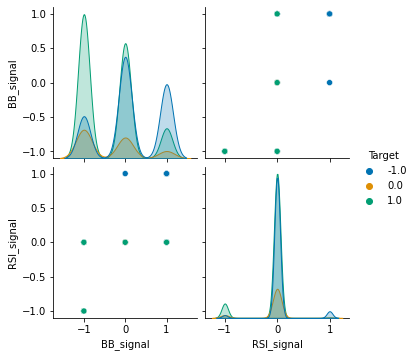

In [70]:
# use pairplots to visualize strength of signals 
sns.pairplot(signals_df[signals+['Target']],hue='Target',palette='colorblind')

## Prepare the Machine Learning Models
---

### Split the data into training and testing datasets

In [71]:
# Assign Target column to a features DataFrame called X
X = signals_df[signals].iloc[:-1]

# Review the DataFrame
X.tail()

BB_signal  RSI_signal
Date                             
2020-12-23        0.0         0.0
2020-12-24        0.0         0.0
2020-12-28       -1.0         0.0
2020-12-29       -1.0         0.0
2020-12-30       -1.0         0.0

In [72]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df.iloc[:-1]['Target']

# Review the value counts
y.value_counts()

 1.0    2391
-1.0    1998
 0.0     637
Name: Target, dtype: int64

In [73]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2001-01-09 00:00:00


In [74]:
# Select the ending period for the training data with an offset of 14 years (70%)
training_end = training_begin + DateOffset(years=14)

# Display the training end date
print(training_end)

2015-01-09 00:00:00


In [75]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.tail()

BB_signal  RSI_signal
Date                             
2015-01-05        1.0         0.0
2015-01-06        1.0         0.0
2015-01-07        0.0         0.0
2015-01-08        0.0         0.0
2015-01-09        0.0         0.0

In [76]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(days=1):]
y_test = y.loc[training_end+DateOffset(days=1):]

# Review the X_test DataFrame
X_test.head()

BB_signal  RSI_signal
Date                             
2015-01-12        0.0         0.0
2015-01-13        0.0         0.0
2015-01-14        1.0         0.0
2015-01-15        1.0         0.0
2015-01-16        0.0         0.0

In [77]:
#scale the data w/ minmax scaler as all obeservations are in range [-1:1]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled,columns=X_train.columns)

In [78]:
X_train_scaled_df.describe().T.round(2)

count  mean   std  min  25%  50%  75%  max
BB_signal   3522.0  0.43  0.37  0.0  0.0  0.5  0.5  1.0
RSI_signal  3522.0  0.48  0.13  0.0  0.5  0.5  0.5  1.0

# Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression

# Create model
model = LogisticRegression()

# Train model
model.fit(X_train, y_train)

LogisticRegression()

In [89]:
# Predict on train dataset
y_pred_train = model.predict(X_train_scaled)
# Predict on test dataset
y_pred = model.predict(X_test_scaled)

## Model Evaluation

In [90]:
from sklearn.metrics import accuracy_score

#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 0.43668370244179444
Model accuracy on testing data: 0.425531914893617
              precision    recall  f1-score   support

        -1.0       0.40      0.97      0.57       573
         0.0       0.00      0.00      0.00       222
         1.0       0.69      0.12      0.20       709

    accuracy                           0.43      1504
   macro avg       0.36      0.36      0.26      1504
weighted avg       0.48      0.43      0.31      1504



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Backtesting

In [91]:
# Create a new empty predictions DataFrame.
predictions_df = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [92]:
predictions_df['Date'] = y_test
predictions_df.drop(columns=['Date'])

# Add the model predictions to the DataFrame
predictions_df['Predicted'] = y_pred


# Add the model predictions to the DataFrame
predictions_df['Target']=signals_df['Target']
predictions_df

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']
predictions_df

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted'].shift()
predictions_df

# add column for cumulative returns
predictions_df['cumulative_rtns'] = (1 + (predictions_df['Strategy Returns'])).cumprod()

# add column for cumulative returns
predictions_df['long_only_rtns'] = (1 + (predictions_df['Actual Returns'])).cumprod()

# Add the strategy returns to the DataFrame
predictions_df['Close'] = signals_df['Close']
predictions_df

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df['Entry/Exit'] = predictions_df['Predicted'].diff()


predictions_df

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                    
2015-01-12  -1.0       -1.0    -1.0       -0.007834               NaN   
2015-01-13  -1.0       -1.0    -1.0       -0.002813          0.002813   
2015-01-14  -1.0       -1.0    -1.0       -0.006037          0.006037   
2015-01-15  -1.0       -1.0    -1.0       -0.009161          0.009161   
2015-01-16   1.0       -1.0     1.0        0.013114         -0.013114   
...          ...        ...     ...             ...               ...   
2020-12-23   0.0       -1.0     0.0        0.000899         -0.000899   
2020-12-24   1.0       -1.0     1.0        0.003890         -0.003890   
2020-12-28   1.0       -1.0     1.0        0.008591         -0.008591   
2020-12-29  -1.0       -1.0    -1.0       -0.001908          0.001908   
2020-12-30   1.0       -1.0     1.0        0.001427         -0.001427   

            cumulative_rtns  long_only_rtns       Close  Entry/Exit  
Date                                                                 
2015-01-12              NaN        0.992166  202.649994         NaN  
2015-01-13         1.002813        0.989376  202.080002         0.0  
2015-01-14         1.008867        0.983403  200.860001         0.0  
2015-01-15         1.018109        0.974394  199.020004         0.0  
2015-01-16         1.004757        0.987173  201.630005         0.0  
...                     ...             ...         ...         ...  
2020-12-23         0.483456        1.799608  367.570007         0.0  
2020-12-24         0.481575        1.806610  369.000000         0.0  
2020-12-28         0.477438        1.822130  372.170013         0.0  
2020-12-29         0.478349        1.818654  371.459991         0.0  
2020-12-30         0.477667        1.821248  371.989990         0.0  

[1504 rows x 9 columns]

In [94]:
# Visualize exit position relative to close price
exit = predictions_df[predictions_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df[predictions_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

<AxesSubplot:xlabel='Date'>

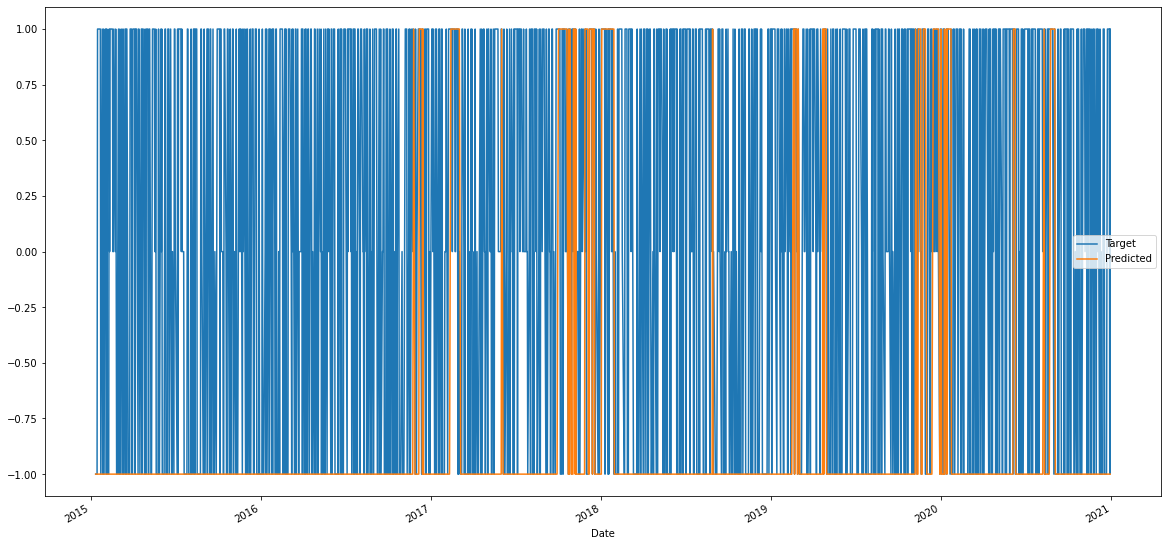

In [85]:
# Plot predicted results vs. actual results
predictions_df[['Target', 'Predicted']].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

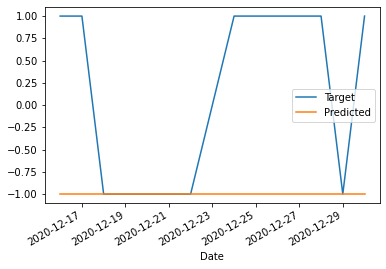

In [86]:
# Plot last 10 records of predicted vs. actual results
predictions_df[['Target', 'Predicted']].tail(10).plot()

From 2015-01-12 to 2020-12-30, this trading algorithm has returned -52.23% with a standard deviation of 14.029287850574427 vs a long-only return of 82.12% and a standard deviation of 22.014813655294432


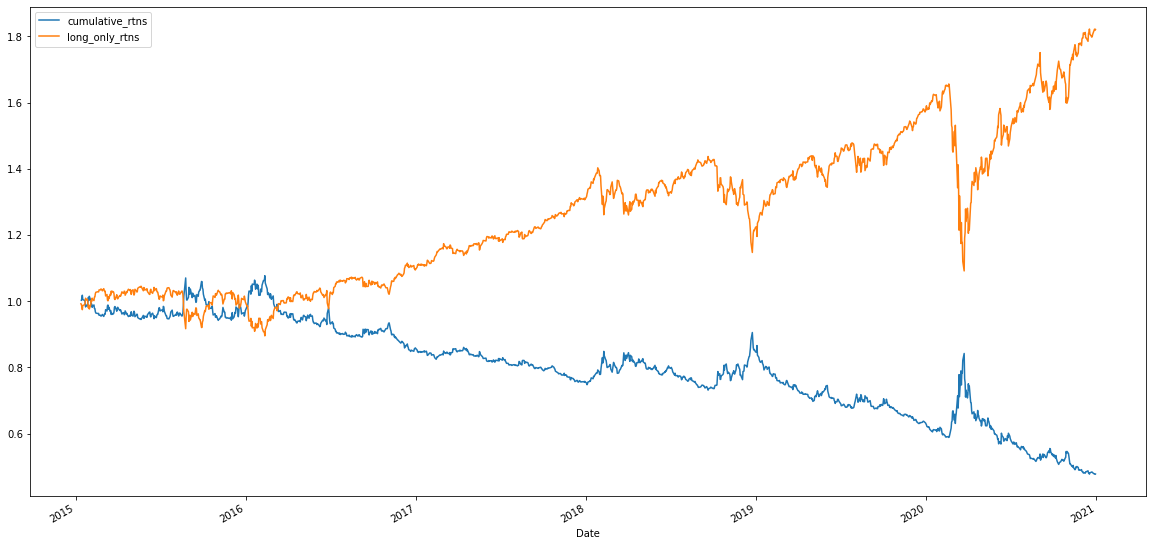

In [87]:
# Plot Cum Returns of Strategy
predictions_df[['cumulative_rtns','long_only_rtns']].plot(figsize=(20,10))

cum_rtn = (predictions_df['cumulative_rtns'].iloc[-1] - 1)*100
long_rtn = (predictions_df['long_only_rtns'].iloc[-1] - 1)*100

cum_std = (predictions_df['cumulative_rtns'].std())*100
long_std = (predictions_df['long_only_rtns'].std())*100

series_begin = predictions_df.index.min().date()
series_end = predictions_df.index.max().date()

print(f'From {series_begin} to {series_end}, this trading algorithm has returned {cum_rtn.round(2)}% with a standard deviation of {cum_std} vs a long-only return of {long_rtn.round(2)}% and a standard deviation of {long_std}')

<AxesSubplot:xlabel='Date'>

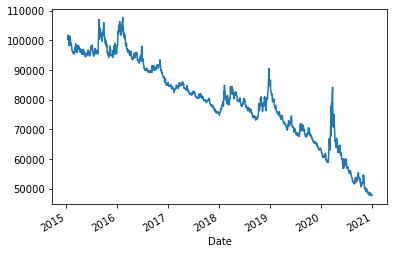

In [36]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (predictions_df['Strategy Returns'])).cumprod()
cumulative_return_capital.plot()

## ADABoostClassifier

In [37]:
from sklearn.ensemble import AdaBoostClassifier

# Create model
model = AdaBoostClassifier()

# Train model
model.fit(X_train_scaled, y_train)

AdaBoostClassifier()

In [38]:
# Predict on train dataset
y_pred_train = model.predict(X_train_scaled)
# Predict on test dataset
y_pred = model.predict(X_test_scaled)

In [39]:
#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 0.5712663259511641
Model accuracy on testing data: 0.5412234042553191
              precision    recall  f1-score   support

        -1.0       0.66      0.29      0.40       573
         0.0       0.00      0.00      0.00       222
         1.0       0.52      0.92      0.66       709

    accuracy                           0.54      1504
   macro avg       0.39      0.40      0.35      1504
weighted avg       0.50      0.54      0.46      1504



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Backtesting

In [40]:
# Create a new empty predictions DataFrame.
predictions_df = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [41]:
predictions_df['Date'] = y_test
predictions_df.drop(columns=['Date'])

# Add the model predictions to the DataFrame
predictions_df['Predicted'] = y_pred


# Add the model predictions to the DataFrame
predictions_df['Target']=signals_df['Target']
predictions_df

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']
predictions_df

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted'].shift()
predictions_df

# add column for cumulative returns
predictions_df['cumulative_rtns'] = (1 + (predictions_df['Strategy Returns'])).cumprod()

# add column for cumulative returns
predictions_df['long_only_rtns'] = (1 + (predictions_df['Actual Returns'])).cumprod()

# Add the strategy returns to the DataFrame
predictions_df['Close'] = signals_df['Close']
predictions_df

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df['Entry/Exit'] = predictions_df['Predicted'].diff()


predictions_df

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                    
2015-01-12  -1.0        1.0    -1.0       -0.007834               NaN   
2015-01-13  -1.0        1.0    -1.0       -0.002813         -0.002813   
2015-01-14  -1.0       -1.0    -1.0       -0.006037         -0.006037   
2015-01-15  -1.0       -1.0    -1.0       -0.009161          0.009161   
2015-01-16   1.0        1.0     1.0        0.013114         -0.013114   
...          ...        ...     ...             ...               ...   
2020-12-23   0.0        1.0     0.0        0.000899          0.000899   
2020-12-24   1.0        1.0     1.0        0.003890          0.003890   
2020-12-28   1.0        1.0     1.0        0.008591          0.008591   
2020-12-29  -1.0        1.0    -1.0       -0.001908         -0.001908   
2020-12-30   1.0        1.0     1.0        0.001427          0.001427   

            cumulative_rtns  long_only_rtns       Close  Entry/Exit  
Date                                                                 
2015-01-12              NaN        0.992166  202.649994         NaN  
2015-01-13         0.997187        0.989376  202.080002         0.0  
2015-01-14         0.991167        0.983403  200.860001        -2.0  
2015-01-15         1.000247        0.974394  199.020004         0.0  
2015-01-16         0.987129        0.987173  201.630005         2.0  
...                     ...             ...         ...         ...  
2020-12-23         1.389244        1.799608  367.570007         0.0  
2020-12-24         1.394649        1.806610  369.000000         0.0  
2020-12-28         1.406630        1.822130  372.170013         0.0  
2020-12-29         1.403946        1.818654  371.459991         0.0  
2020-12-30         1.405950        1.821248  371.989990         0.0  

[1504 rows x 9 columns]

In [42]:
# Visualize exit position relative to close price
exit = predictions_df[predictions_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df[predictions_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

<AxesSubplot:xlabel='Date'>

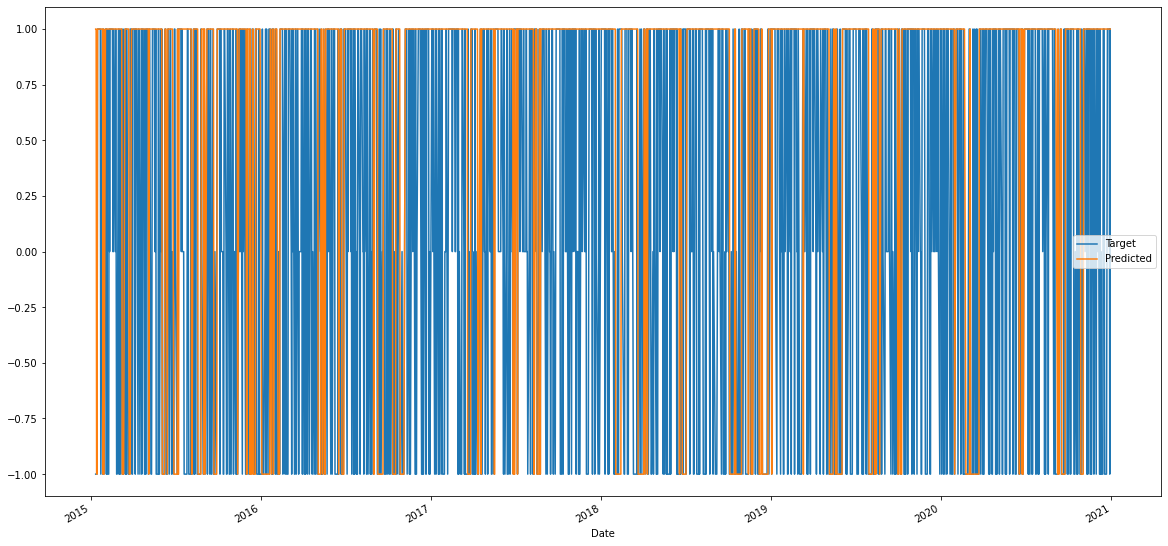

In [43]:
# Plot predicted results vs. actual results
predictions_df[['Target', 'Predicted']].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

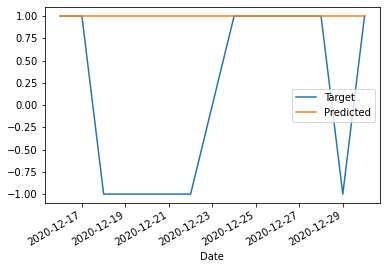

In [44]:
# Plot last 10 records of predicted vs. actual results
predictions_df[['Target', 'Predicted']].tail(10).plot()

From 2015-01-12 to 2020-12-30, this trading algorithm has returned 40.59% with a standard deviation of 18.01850691878696 vs a long-only return of 82.12% and a standard deviation of 22.014813655294432


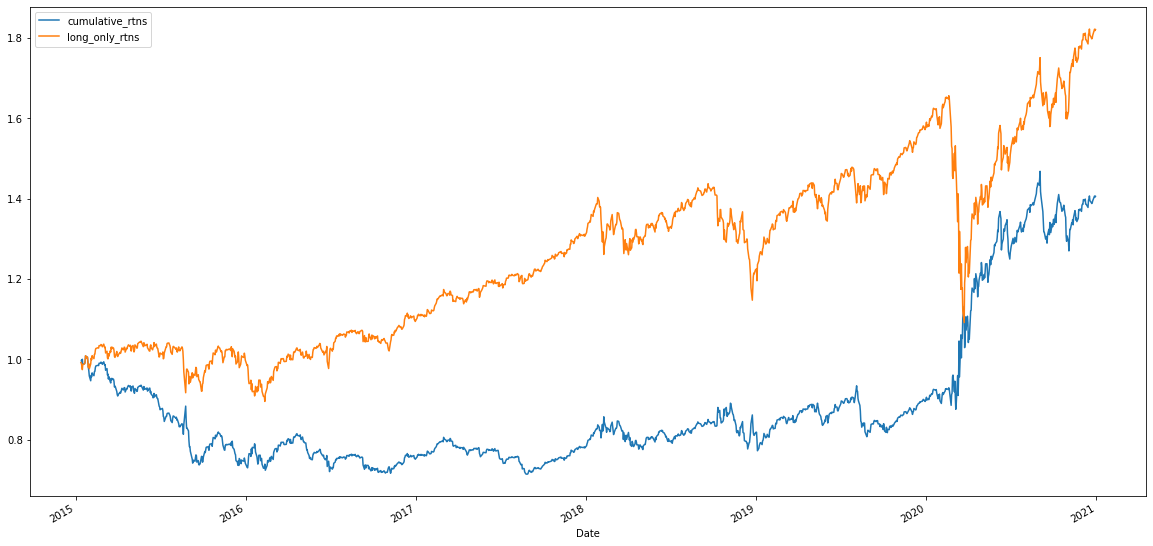

In [45]:
# Plot Cum Returns of Strategy
predictions_df[['cumulative_rtns','long_only_rtns']].plot(figsize=(20,10))

cum_rtn = (predictions_df['cumulative_rtns'].iloc[-1] - 1)*100
long_rtn = (predictions_df['long_only_rtns'].iloc[-1] - 1)*100

cum_std = (predictions_df['cumulative_rtns'].std())*100
long_std = (predictions_df['long_only_rtns'].std())*100

series_begin = predictions_df.index.min().date()
series_end = predictions_df.index.max().date()

print(f'From {series_begin} to {series_end}, this trading algorithm has returned {cum_rtn.round(2)}% with a standard deviation of {cum_std} vs a long-only return of {long_rtn.round(2)}% and a standard deviation of {long_std}')

<AxesSubplot:xlabel='Date'>

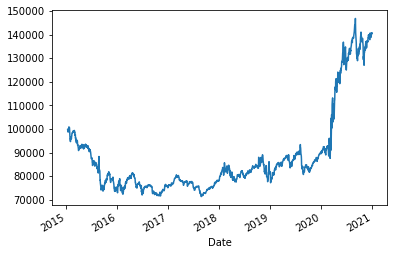

In [46]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (predictions_df['Strategy Returns'])).cumprod()
cumulative_return_capital.plot()

# DecisionTree Classifier

In [47]:
from sklearn.tree import DecisionTreeClassifier

# Create model
model = DecisionTreeClassifier()

# Train model
model.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [48]:
# Predict on train dataset
y_pred_train = model.predict(X_train_scaled)
# Predict on test dataset
y_pred = model.predict(X_test_scaled)

In [49]:
#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 0.5721181147075525
Model accuracy on testing data: 0.5392287234042553
              precision    recall  f1-score   support

        -1.0       0.66      0.28      0.40       573
         0.0       0.00      0.00      0.00       222
         1.0       0.52      0.92      0.66       709

    accuracy                           0.54      1504
   macro avg       0.39      0.40      0.35      1504
weighted avg       0.49      0.54      0.46      1504



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Backtesting

In [50]:
# Create a new empty predictions DataFrame.
predictions_df = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [51]:
predictions_df['Date'] = y_test
predictions_df.drop(columns=['Date'])

# Add the model predictions to the DataFrame
predictions_df['Predicted'] = y_pred


# Add the model predictions to the DataFrame
predictions_df['Target']=signals_df['Target']
predictions_df

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']
predictions_df

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted'].shift()
predictions_df

# add column for cumulative returns
predictions_df['cumulative_rtns'] = (1 + (predictions_df['Strategy Returns'])).cumprod()

# add column for cumulative returns
predictions_df['long_only_rtns'] = (1 + (predictions_df['Actual Returns'])).cumprod()

# Add the strategy returns to the DataFrame
predictions_df['Close'] = signals_df['Close']
predictions_df

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df['Entry/Exit'] = predictions_df['Predicted'].diff()


predictions_df

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                    
2015-01-12  -1.0        1.0    -1.0       -0.007834               NaN   
2015-01-13  -1.0        1.0    -1.0       -0.002813         -0.002813   
2015-01-14  -1.0       -1.0    -1.0       -0.006037         -0.006037   
2015-01-15  -1.0       -1.0    -1.0       -0.009161          0.009161   
2015-01-16   1.0        1.0     1.0        0.013114         -0.013114   
...          ...        ...     ...             ...               ...   
2020-12-23   0.0        1.0     0.0        0.000899          0.000899   
2020-12-24   1.0        1.0     1.0        0.003890          0.003890   
2020-12-28   1.0        1.0     1.0        0.008591          0.008591   
2020-12-29  -1.0        1.0    -1.0       -0.001908         -0.001908   
2020-12-30   1.0        1.0     1.0        0.001427          0.001427   

            cumulative_rtns  long_only_rtns       Close  Entry/Exit  
Date                                                                 
2015-01-12              NaN        0.992166  202.649994         NaN  
2015-01-13         0.997187        0.989376  202.080002         0.0  
2015-01-14         0.991167        0.983403  200.860001        -2.0  
2015-01-15         1.000247        0.974394  199.020004         0.0  
2015-01-16         0.987129        0.987173  201.630005         2.0  
...                     ...             ...         ...         ...  
2020-12-23         1.365968        1.799608  367.570007         0.0  
2020-12-24         1.371282        1.806610  369.000000         0.0  
2020-12-28         1.383062        1.822130  372.170013         0.0  
2020-12-29         1.380424        1.818654  371.459991         0.0  
2020-12-30         1.382393        1.821248  371.989990         0.0  

[1504 rows x 9 columns]

In [52]:
# Visualize exit position relative to close price
exit = predictions_df[predictions_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df[predictions_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

<AxesSubplot:xlabel='Date'>

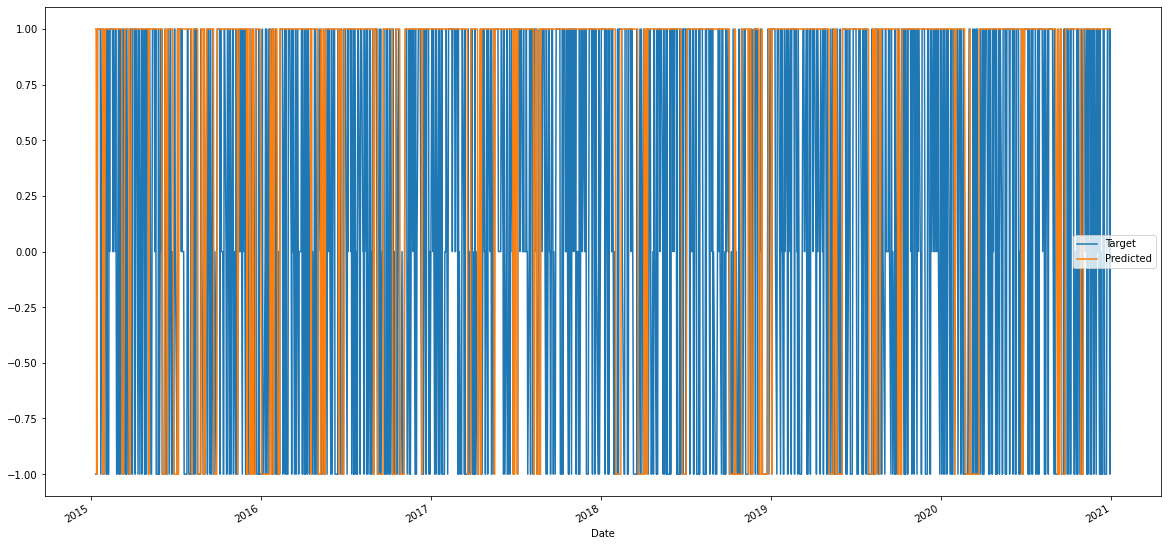

In [53]:
# Plot predicted results vs. actual results
predictions_df[['Target', 'Predicted']].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

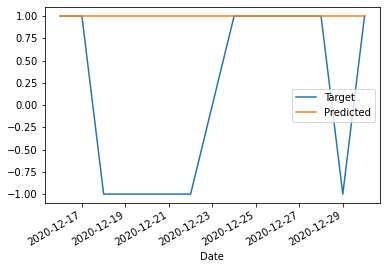

In [54]:
# Plot last 10 records of predicted vs. actual results
predictions_df[['Target', 'Predicted']].tail(10).plot()

From 2015-01-12 to 2020-12-30, this trading algorithm has returned 38.24% with a standard deviation of 17.980398125099228 vs a long-only return of 82.12% and a standard deviation of 22.014813655294432


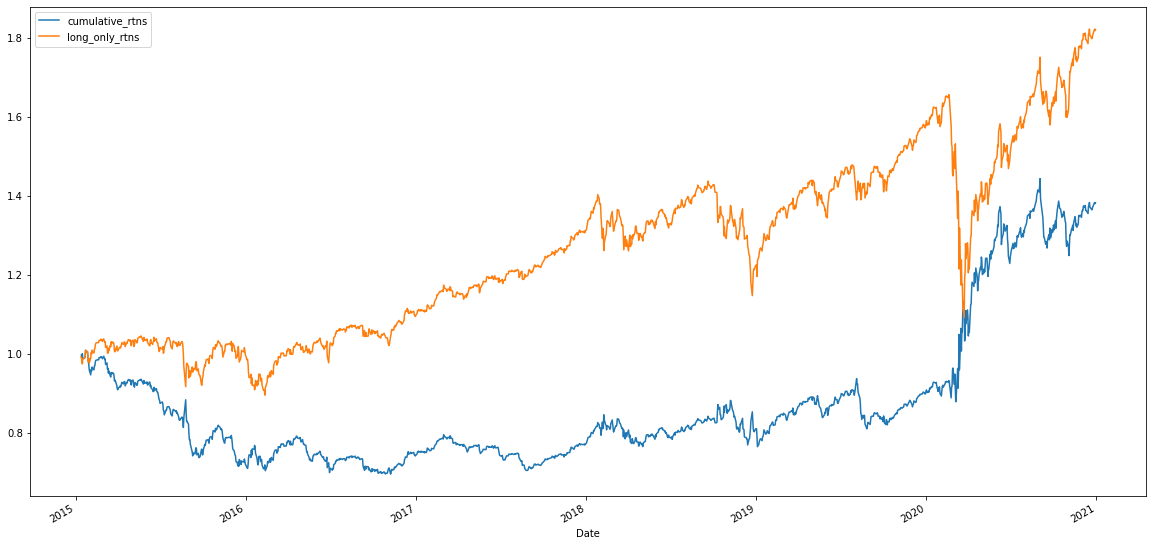

In [55]:
# Plot Cum Returns of Strategy
predictions_df[['cumulative_rtns','long_only_rtns']].plot(figsize=(20,10))

cum_rtn = (predictions_df['cumulative_rtns'].iloc[-1] - 1)*100
long_rtn = (predictions_df['long_only_rtns'].iloc[-1] - 1)*100

cum_std = (predictions_df['cumulative_rtns'].std())*100
long_std = (predictions_df['long_only_rtns'].std())*100

series_begin = predictions_df.index.min().date()
series_end = predictions_df.index.max().date()

print(f'From {series_begin} to {series_end}, this trading algorithm has returned {cum_rtn.round(2)}% with a standard deviation of {cum_std} vs a long-only return of {long_rtn.round(2)}% and a standard deviation of {long_std}')

<AxesSubplot:xlabel='Date'>

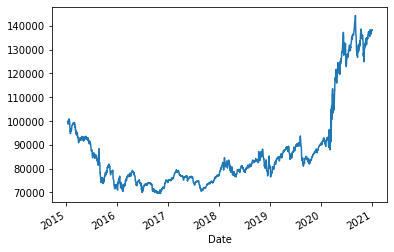

In [56]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (predictions_df['Strategy Returns'])).cumprod()
cumulative_return_capital.plot()

# Gradient Boosting Classifier

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

# Create model
model = GradientBoostingClassifier()

# Train model
model.fit(X_train_scaled, y_train)

GradientBoostingClassifier()

In [58]:
# Predict on train dataset
y_pred_train = model.predict(X_train_scaled)
# Predict on test dataset
y_pred = model.predict(X_test_scaled)

In [59]:
#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 0.5721181147075525
Model accuracy on testing data: 0.5398936170212766
              precision    recall  f1-score   support

        -1.0       0.66      0.28      0.40       573
         0.0       0.00      0.00      0.00       222
         1.0       0.52      0.92      0.66       709

    accuracy                           0.54      1504
   macro avg       0.39      0.40      0.35      1504
weighted avg       0.50      0.54      0.46      1504



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Backtesting

In [60]:
# Create a new empty predictions DataFrame.
predictions_df = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [61]:
predictions_df['Date'] = y_test
predictions_df.drop(columns=['Date'])

# Add the model predictions to the DataFrame
predictions_df['Predicted'] = y_pred


# Add the model predictions to the DataFrame
predictions_df['Target']=signals_df['Target']
predictions_df

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']
predictions_df

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted'].shift()
predictions_df

# add column for cumulative returns
predictions_df['cumulative_rtns'] = (1 + (predictions_df['Strategy Returns'])).cumprod()

# add column for cumulative returns
predictions_df['long_only_rtns'] = (1 + (predictions_df['Actual Returns'])).cumprod()

# Add the strategy returns to the DataFrame
predictions_df['Close'] = signals_df['Close']
predictions_df

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df['Entry/Exit'] = predictions_df['Predicted'].diff()


predictions_df

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                    
2015-01-12  -1.0        1.0    -1.0       -0.007834               NaN   
2015-01-13  -1.0        1.0    -1.0       -0.002813         -0.002813   
2015-01-14  -1.0       -1.0    -1.0       -0.006037         -0.006037   
2015-01-15  -1.0       -1.0    -1.0       -0.009161          0.009161   
2015-01-16   1.0        1.0     1.0        0.013114         -0.013114   
...          ...        ...     ...             ...               ...   
2020-12-23   0.0        1.0     0.0        0.000899          0.000899   
2020-12-24   1.0        1.0     1.0        0.003890          0.003890   
2020-12-28   1.0        1.0     1.0        0.008591          0.008591   
2020-12-29  -1.0        1.0    -1.0       -0.001908         -0.001908   
2020-12-30   1.0        1.0     1.0        0.001427          0.001427   

            cumulative_rtns  long_only_rtns       Close  Entry/Exit  
Date                                                                 
2015-01-12              NaN        0.992166  202.649994         NaN  
2015-01-13         0.997187        0.989376  202.080002         0.0  
2015-01-14         0.991167        0.983403  200.860001        -2.0  
2015-01-15         1.000247        0.974394  199.020004         0.0  
2015-01-16         0.987129        0.987173  201.630005         2.0  
...                     ...             ...         ...         ...  
2020-12-23         1.368573        1.799608  367.570007         0.0  
2020-12-24         1.373898        1.806610  369.000000         0.0  
2020-12-28         1.385701        1.822130  372.170013         0.0  
2020-12-29         1.383057        1.818654  371.459991         0.0  
2020-12-30         1.385030        1.821248  371.989990         0.0  

[1504 rows x 9 columns]

In [62]:
# Visualize exit position relative to close price
exit = predictions_df[predictions_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df[predictions_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

<AxesSubplot:xlabel='Date'>

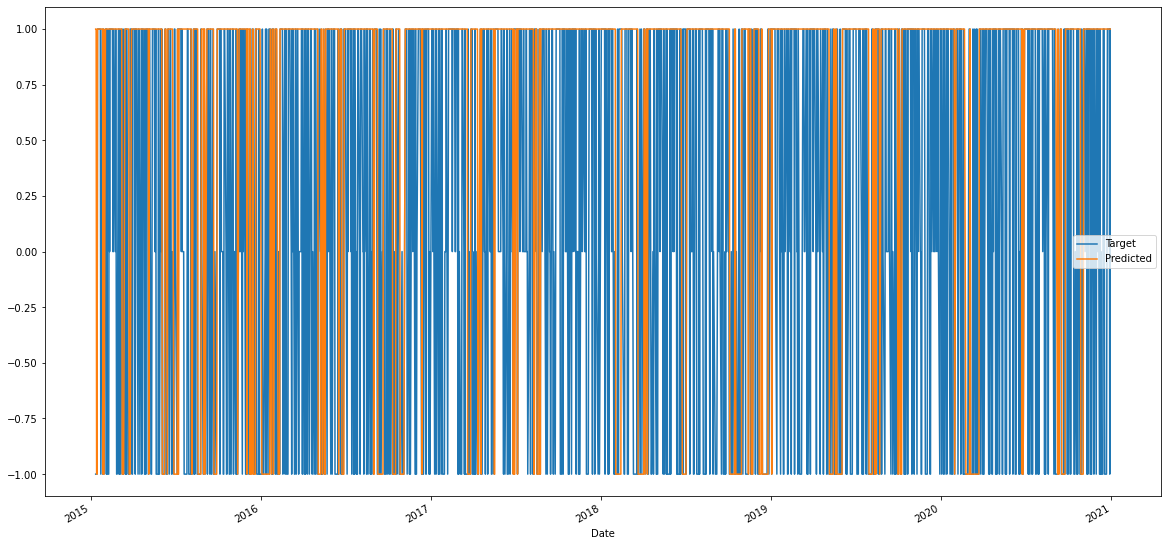

In [63]:
# Plot predicted results vs. actual results
predictions_df[['Target', 'Predicted']].plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

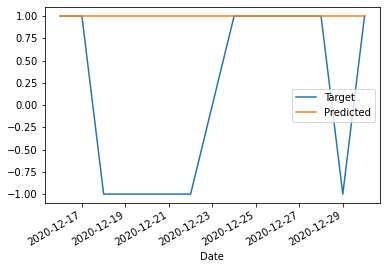

In [64]:
# Plot last 10 records of predicted vs. actual results
predictions_df[['Target', 'Predicted']].tail(10).plot()

From 2015-01-12 to 2020-12-30, this trading algorithm has returned 38.5% with a standard deviation of 18.019447036932075 vs a long-only return of 82.12% and a standard deviation of 22.014813655294432


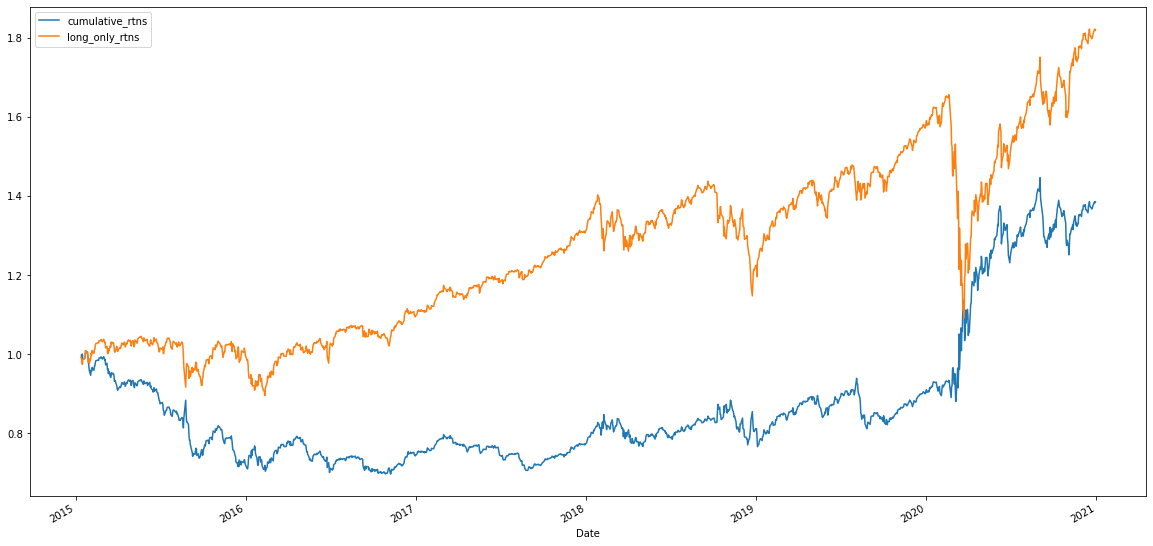

In [65]:
# Plot Cum Returns of Strategy
predictions_df[['cumulative_rtns','long_only_rtns']].plot(figsize=(20,10))

cum_rtn = (predictions_df['cumulative_rtns'].iloc[-1] - 1)*100
long_rtn = (predictions_df['long_only_rtns'].iloc[-1] - 1)*100

cum_std = (predictions_df['cumulative_rtns'].std())*100
long_std = (predictions_df['long_only_rtns'].std())*100

series_begin = predictions_df.index.min().date()
series_end = predictions_df.index.max().date()

print(f'From {series_begin} to {series_end}, this trading algorithm has returned {cum_rtn.round(2)}% with a standard deviation of {cum_std} vs a long-only return of {long_rtn.round(2)}% and a standard deviation of {long_std}')

<AxesSubplot:xlabel='Date'>

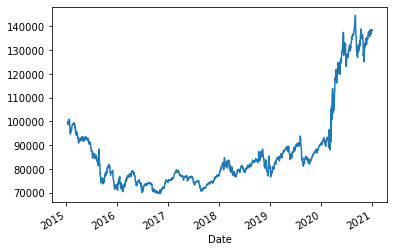

In [66]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (predictions_df['Strategy Returns'])).cumprod()
cumulative_return_capital.plot()

# Evaluation
___

## Prep Evaluation Metrics Dataframe

In [254]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']

columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics and column = trading staregy
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
portfolio_evaluation_df

Backtest
Annual Return           NaN
Cumulative Returns      NaN
Annual Volatility       NaN
Sharpe Ratio            NaN
Sortino Ratio           NaN

## Calculate and Assign Portfolio Metrics

In [105]:
# Calculate cumulative return
portfolio_evaluation_df.loc['Cumulative Returns'] = _df['Portfolio Cumulative Returns'][-1]

# Calculate annualized return
portfolio_evaluation_df.loc['Annual Return'] = (
    master_df['Portfolio Daily Returns'].mean() * 252
)

# Calculate annual volatility
portfolio_evaluation_df.loc['Annual Volatility'] = (
    master_df['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    master_df['Portfolio Daily Returns'].mean() * 252) / (
    master_df['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Downside Return
sortino_ratio_df = master_df[['Portfolio Daily Returns']]
sortino_ratio_df.loc[:,'Downside Returns'] = 0
sortino_ratio_df.head()

target = 0
mask = sortino_ratio_df['Portfolio Daily Returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2

# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
sortino_ratio = expected_return/down_stdev

portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
portfolio_evaluation_df.head()

NameError: name '_df' is not defined

## Prepare Trade Evaluation Metrics

In [129]:
# Initialize trade evaluation DataFrame with columns
trade_evaluation_df = pd.DataFrame(
    columns=[
        'Stock', 
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
)

trade_evaluation_df

Empty DataFrame
Columns: [Stock, Entry Date, Exit Date, Shares, Entry Share Price, Exit Share Price, Entry Portfolio Holding, Exit Portfolio Holding, Profit/Loss]
Index: []

In [131]:
# Initialize iterative variables
entry_date = ''
exit_date = ''
entry_portfolio_holding = 0
exit_portfolio_holding = 0
share_size = 0
entry_share_price = 0
exit_share_price = 0

# Loop through signal DataFrame
# If `Entry/Exit` is 1, set entry trade metrics
# Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
# Then append the record to the trade evaluation DataFrame
for index, row in master_df.iterrows():
    if row['Entry/Exit'] == 1:
        entry_date = index
        entry_portfolio_holding = abs(row['Portfolio Holdings'])
        share_size = row['Entry/Exit Position']
        entry_share_price = row['Close']

    elif row['Entry/Exit'] == -1:
        exit_date = index
        exit_portfolio_holding = abs(row['Close'] * row['Entry/Exit Position'])
        exit_share_price = row['Close']
        profit_loss =  entry_portfolio_holding - exit_portfolio_holding
        trade_evaluation_df = trade_evaluation_df.append(
            {
                'Stock': 'AAPL',
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Shares': share_size,
                'Entry Share Price': entry_share_price,
                'Exit Share Price': exit_share_price,
                'Entry Portfolio Holding': entry_portfolio_holding,
                'Exit Portfolio Holding': exit_portfolio_holding,
                'Profit/Loss': profit_loss
            },
            ignore_index=True)

# Print the DataFrame
trade_evaluation_df.head()

Stock Entry Date  Exit Date  Shares  Entry Share Price  Exit Share Price  \
0  AAPL 2000-09-29 2000-10-23     0.0           0.459821          0.363839   
1  AAPL 2000-10-24 2000-10-30     0.0           0.337054          0.344866   
2  AAPL 2000-12-06 2000-12-08     0.0           0.255580          0.268973   
3  AAPL 2002-06-19 2002-06-27     0.0           0.305714          0.304643   
4  AAPL 2008-01-23 2008-01-31     0.0           4.966786          4.834286   

   Entry Portfolio Holding  Exit Portfolio Holding  Profit/Loss  
0               229.910493                0.000000   229.910493  
1                 0.000000              172.433004  -172.433004  
2               127.790004                0.000000   127.790004  
3               152.857006                0.000000   152.857006  
4              2483.392954                0.000000  2483.392954